# Implement Kalman model using FastAI

> need to implement custom data preparation pipeline and loss function 

## Data Preparation

The aim of the data preparation pipeline is to:
- take the original time series and split it into time blocks
- for each block generate a random gap (need to figure out the properties of the gap)
- split some time blocks for testing

the input of the pipeline is:
- a dataframe containing all observations

the input of the model is:
- observed data (potentially containing NaN where data is missing)
- missing data mask (which is telling where the data is missing)
- the data needs to be standardized

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
#| hide
#| default_exp kalman.fastai

In [ ]:
#| export
from meteo_imp.utils import *
from meteo_imp.gaussian import *

In [ ]:
reset_seed()

In [ ]:
import torch

In [ ]:
from fastai.tabular.core import *
from fastai.data.core import *

In [ ]:
#| export
from fastcore.transform import *
from fastcore.basics import *
from fastcore.foundation import *
from fastcore.all import *
from fastai.tabular import *
from fastai.torch_core import default_device, to_cpu

from meteo_imp.data import read_fluxnet_csv, hai_path

import collections

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
@cache_disk(cache_dir / "full_hai")
def load_data(dtype=np.float32):
    return read_fluxnet_csv(hai_path, None, num_dtype=dtype)

hai = load_data()
hai64 = load_data(np.float64)

### 1) Blocks

the first step is to transfrom the original dataframe into blocks of a specified `block_len`

two different strategies are possible:

- contigous blocks
- random block in the dataframe

In [ ]:
#| export
class BlockDfTransform(Transform):
    """divide timeseries DataFrame into blocks"""
    def __init__(self, df, block_len=200): 
        self.df = df 
        self.block_len = block_len
        self.n = len(df)
        
    def encodes(self, i:int) -> pd.DataFrame:       
        start = i * self.block_len
        end = (i+1) * self.block_len
        assert end <= self.n 
        
        block = self.df[start:end]
        
        return block

In [ ]:
blk = BlockDfTransform(hai, 10)

In [ ]:
blk

BlockDfTransform:
encodes: (int,object) -> encodes
decodes: 

In [ ]:
blk(1)

,TA,SW_IN,VPD
time,,,
2000-01-01 05:30:00,-0.23,0.00,0.138
2000-01-01 06:00:00,-0.23,0.00,0.122
2000-01-01 06:30:00,-0.22,0.00,0.098
2000-01-01 07:00:00,-0.24,0.00,0.066
2000-01-01 07:30:00,-0.23,0.00,0.044
2000-01-01 08:00:00,-0.22,0.00,0.026
2000-01-01 08:30:00,-0.19,0.45,0.016
2000-01-01 09:00:00,-0.14,3.70,0.010
2000-01-01 09:30:00,-0.03,7.26,0.006


In [ ]:
180 * 24 * 2 / 10

864.0

we are taking a day in the summer so there is an higher values for the variables

In [ ]:
blk(800)

,TA,SW_IN,VPD
time,,,
2000-06-15 16:30:00,14.65,468.190002,6.454
2000-06-15 17:00:00,14.22,224.800003,5.799
2000-06-15 17:30:00,14.11,195.279999,6.577
2000-06-15 18:00:00,14.23,244.169998,6.931
2000-06-15 18:30:00,14.40,253.919998,7.286
2000-06-15 19:00:00,14.09,177.309998,7.251
2000-06-15 19:30:00,13.71,97.070000,6.683
2000-06-15 20:00:00,13.08,39.709999,5.851
2000-06-15 20:30:00,12.41,10.650000,5.254


In [ ]:
tfms1 = TfmdLists([800,801,802,803], [BlockDfTransform(hai, 10)])

In [ ]:
tfms1[0]

,TA,SW_IN,VPD
time,,,
2000-06-15 16:30:00,14.65,468.190002,6.454
2000-06-15 17:00:00,14.22,224.800003,5.799
2000-06-15 17:30:00,14.11,195.279999,6.577
2000-06-15 18:00:00,14.23,244.169998,6.931
2000-06-15 18:30:00,14.40,253.919998,7.286
2000-06-15 19:00:00,14.09,177.309998,7.251
2000-06-15 19:30:00,13.71,97.070000,6.683
2000-06-15 20:00:00,13.08,39.709999,5.851
2000-06-15 20:30:00,12.41,10.650000,5.254


### 2) Gaps

adds a mask which includes a random gap

In [ ]:
class MaskedDf:
    def __init__(self,*args):
        self.data = args[0]
        self.mask = args[1]
    def __iter__(self): return iter((self.data, self.mask,))
    __repr__ = basic_repr("data, mask")
    def _repr_html_(self):
        return row_dfs({'data': self.data, 'mask': self.mask}, title="Masked Df")

In [ ]:
#| exports
def _make_random_gap(
    gap_length: int, # The length of the gap
    total_length: int, # The total number of observations
    gap_start: int = None # Optional start of gap
): # (total_length) array of bools to indicicate if the data is missing or not
    "Add a continous gap of ginve length at random position"
    if(gap_length >= total_length):
        return np.repeat(True, total_length)
    gap_start = np.random.randint(total_length - gap_length) if gap_start is None else gap_start
    return np.hstack([
        np.repeat(False, gap_start),
        np.repeat(True, gap_length),
        np.repeat(False, total_length - (gap_length + gap_start))
    ])

In [ ]:
#| export
from fastcore.basics import *

In [ ]:
#| export
class AddGapTransform(Transform):
    """Adds a random gap to a `TimeSTensor`"""
    def __init__(self,
                variables,
                gap_length,
                ):
        store_attr()
    def encodes(self, df: pd.DataFrame):
        gap = _make_random_gap(self.gap_length, df.shape[0])
        mask = np.ones_like(df, dtype=bool)
        col_sel = L(*df.columns).argwhere(lambda x: x in self.variables)
        mask[np.argwhere(gap), col_sel] = False
        return MaskedDf(df, pd.DataFrame(mask, index=df.index, columns=df.columns))

In [ ]:
a_gap = AddGapTransform(['TA', 'VPD'], 5)
a_gap

AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: 

In [ ]:
a_gap(blk(800))

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


In [ ]:
m_df = a_gap(blk(800))

In [ ]:
display_as_row({'data': m_df.data, 'mask': m_df.mask})

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


In [ ]:
tfms2 = TfmdLists([800,801,802,803], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2)])

In [ ]:
tfms2[0]

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


In [ ]:
#| export
@patch
def tidy(self: MaskedDf):
    data = self.data.reset_index().melt("time")
    mask = self.mask.reset_index().melt("time", value_name="is_present")
    
    return pd.merge(data, mask, on=["time", "variable"])

In [ ]:
m_df.tidy()

,time,variable,value,is_present
0,2000-06-15 16:30:00,TA,14.650000,False
1,2000-06-15 17:00:00,TA,14.220000,False
2,2000-06-15 17:30:00,TA,14.110000,False
3,2000-06-15 18:00:00,TA,14.230000,False
4,2000-06-15 18:30:00,TA,14.400000,False
5,2000-06-15 19:00:00,TA,14.090000,True
6,2000-06-15 19:30:00,TA,13.710000,True
7,2000-06-15 20:00:00,TA,13.080000,True
8,2000-06-15 20:30:00,TA,12.410000,True
9,2000-06-15 21:00:00,TA,12.270000,True


#### Plotting

In [ ]:
#| export
import altair as alt
from altair import datum

In [ ]:
#| exporti
def def_selection():
    return alt.selection_interval(bind="scales")

In [ ]:
#| exporti
def plot_rug(df, sel = def_selection(), props = {}):
    if 'height' in props:
        props = props.copy() 
        props.pop('height') # rug should have default heigth
    return alt.Chart(df).mark_tick(
            color='black',
        ).encode(
            x = "time",
            color = alt.condition(datum.is_present, alt.value('white'), alt.value('black'))
        ).add_params(
            sel
        ).properties(**props) 

In [ ]:
plot_rug(m_df.tidy())

alt.Chart(...)

In [ ]:
def plot_points(df, y_label = "", sel = def_selection(), props = {}):
    return alt.Chart(df).mark_point(
            color='black',
            strokeWidth = 1,
            fillOpacity = 1
        ).encode(
            x = alt.X("time"),
            y = alt.Y("value", title = y_label, scale=alt.Scale(zero=False)),
            fill= alt.Fill("is_present", scale = alt.Scale(range=["black", "#ffffff00"]),
                           legend = alt.Legend(title =["Observed data"])),
            shape = "is_present",
        )

In [ ]:
plot_points(m_df.tidy())

alt.Chart(...)

In [ ]:
df = m_df.tidy()

In [ ]:
df = df[df.variable=="TA"].copy()

In [ ]:
df['row_number'] = df.reset_index().index

In [ ]:
df

,time,variable,value,is_present,row_number
0,2000-06-15 16:30:00,TA,14.65,False,0
1,2000-06-15 17:00:00,TA,14.22,False,1
2,2000-06-15 17:30:00,TA,14.11,False,2
3,2000-06-15 18:00:00,TA,14.23,False,3
4,2000-06-15 18:30:00,TA,14.40,False,4
5,2000-06-15 19:00:00,TA,14.09,True,5
6,2000-06-15 19:30:00,TA,13.71,True,6
7,2000-06-15 20:00:00,TA,13.08,True,7
8,2000-06-15 20:30:00,TA,12.41,True,8
9,2000-06-15 21:00:00,TA,12.27,True,9


In [ ]:
df[~df.is_present]

,time,variable,value,is_present,row_number
0,2000-06-15 16:30:00,TA,14.65,False,0
1,2000-06-15 17:00:00,TA,14.22,False,1
2,2000-06-15 17:30:00,TA,14.11,False,2
3,2000-06-15 18:00:00,TA,14.23,False,3
4,2000-06-15 18:30:00,TA,14.40,False,4


In [ ]:
def _find_gaps_limits(df):
    """"""
    
    

In [ ]:
def plot_missing_area(df, sel = def_selection(), props={}):
    

SyntaxError: incomplete input (749152740.py, line 2)

In [ ]:
#| exporti
def plot_line(df, only_present=True, y_label = "", sel = def_selection(), props = {}):
    # df = df[df.is_present] if only_present else df
    # TODO remove onle_present
    return alt.Chart(df).mark_line().encode(
        x = "time",    
        y = alt.Y("value", title = y_label, scale=alt.Scale(zero=False)),
        color='variable'
    ).add_params(
        sel
    ).properties(
        **props
    )#.transform_filter(
    #     datum.is_present
    # )

    

In [ ]:
plot_line(m_df.tidy())

alt.Chart(...)

In [ ]:
#| exporti
def plot_error(df, y_label = "", sel = def_selection(), props = {}):
    df.loc[:,'err_low'] = df.value - 2 * df['std']
    df.loc[:,'err_high'] = df.value + 2 * df['std']
    return alt.Chart(df).mark_errorband().encode(
        x = "time",    
        y = alt.Y("err_low:Q", title = y_label, scale=alt.Scale(zero=False)),
        y2 = "err_high:Q",
        color=alt.Color("variable",
                        legend = alt.Legend(title=["Line: pred. mean", "area: +/- 2 std"])
                       )
    ).add_params(
        sel
    ).properties(
        **props
    )
    

In [ ]:
plot_error(m_df.tidy().assign(std=5))

alt.Chart(...)

In [ ]:
#| exporti
def plot_variable(df, variable, title="", y_label="", sel = None, error=False, props = {}):
    df = df[df.variable == variable].copy()
    sel = ifnone(sel, def_selection())
    # rug = plot_rug(df, sel, props)
    points = plot_points(df, y_label, sel, props)
    line = plot_line(df, True, y_label, sel, props)
    if error: line = plot_error(df, y_label, sel, props) + line
    
    return (points + line).properties(title=title)
    
    # return alt.VConcatChart(vconcat=[(points + line), rug], spacing=-10).properties(title=title)

In [ ]:
plot_variable(m_df.tidy(), "TA", title="title TA")

alt.LayerChart(...)

In [ ]:
plot_variable(m_df.tidy().assign(std=.5), "TA", title="title TA", error=True)

alt.LayerChart(...)

In [ ]:
def facet_variable(df, # tidy dataframe
                   n_cols: int = 3,
                   bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
                   props:dict = None, # additional properties for altair plot (eg. size)
                   error:bool=False # plot error bar
                   ) -> alt.Chart:
    """Plot all values of the column `variable` in different subplots"""
    props = ifnone(props, {'width': 200, 'height': 150})
    vars = df.variable.unique()
    plot_list = [alt.hconcat() for _ in range(0, len(vars), n_cols)]
    selection_scale = alt.selection_interval(bind="scales", encodings=['x']) if bind_interaction else None
    for idx, variable in enumerate(vars):
        plot = plot_variable(df,
                            variable,
                            title = variable,
                            y_label = variable,
                            sel = selection_scale,
                            props=props,
                            error=error)
        
        plot_list[idx // n_cols] |= plot
    
    plot = alt.vconcat(*plot_list)
    
    return plot

In [ ]:
#| export
@patch
def show(self: MaskedDf, ax=None, ctx=None, 
        n_cols: int = 3,
        bind_interaction: bool =True, # Whether the sub-plots for each variable should be connected for zooming/panning
        props:dict = None # additional properties (eg. size) for altair plot
       ) -> alt.Chart:
    
    df = self.tidy()
    return facet_variable(df, n_cols, bind_interaction, props)

In [ ]:
m_df.show()

alt.VConcatChart(...)

In [ ]:
a_gap(blk(799)).show()

alt.VConcatChart(...)

In [ ]:
idx = L(*blk(1).columns).argwhere(lambda x: x in ['TA','SW_IN'])

In [ ]:
mask = np.ones_like(blk(1), dtype=bool)

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
gap = _make_random_gap(2, 10, 2)

In [ ]:
gap

array([False, False,  True,  True, False, False, False, False, False,
       False])

In [ ]:
np.argwhere(gap)

array([[2],
       [3]])

In [ ]:
mask[np.argwhere(gap), idx] = False

In [ ]:
mask

array([[ True,  True,  True],
       [ True,  True,  True],
       [False, False,  True],
       [False, False,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True],
       [ True,  True,  True]])

In [ ]:
mask[gap]

array([[False, False,  True],
       [False, False,  True]])

### To Tensor

this needs to handle both the init with a list of items and when the first item is a sequence of list of items

In [ ]:
class MaskedTensor(collections.abc.Sequence):
    def __init__(self,*args):
        if len(args)==2:
            self.data = args[0]
            self.mask = args[1]
        elif len(args)==1 and len(args[0])==2:
            self.data = args[0][0]
            self.mask = args[0][1]
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")

    def __iter__(self): return iter((self.data, self.mask,))
    __len__ = 2
    def __getitem__(self, key):
        if key == 0: return self.data
        elif key == 1: return self.mask
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('data, mask')

In [ ]:
#| export
class MaskedDf2Tensor(Transform):
    def setups(self, items):
        self.columns = list(items[0].data.columns)
    def encodes(self, df: MaskedDf) -> MaskedTensor:
        data = torch.tensor(df.data.to_numpy())
        mask = torch.tensor(df.mask.to_numpy())
        return MaskedTensor(data, mask)
        
    def decodes(self, x: MaskedTensor) -> MaskedDf:
        data = pd.DataFrame(x.data.detach().cpu().numpy(), columns = self.columns)
        mask = pd.DataFrame(x.mask.cpu().numpy(), columns = self.columns)
        return MaskedDf(data, mask)

In [ ]:
to_t = MaskedDf2Tensor()

In [ ]:
to_t.setup(tfms2)

In [ ]:
to_t(tfms2[0])

__main__.MaskedTensor(data=tensor([[1.4650e+01, 4.6819e+02, 6.4540e+00],
        [1.4220e+01, 2.2480e+02, 5.7990e+00],
        [1.4110e+01, 1.9528e+02, 6.5770e+00],
        [1.4230e+01, 2.4417e+02, 6.9310e+00],
        [1.4400e+01, 2.5392e+02, 7.2860e+00],
        [1.4090e+01, 1.7731e+02, 7.2510e+00],
        [1.3710e+01, 9.7070e+01, 6.6830e+00],
        [1.3080e+01, 3.9710e+01, 5.8510e+00],
        [1.2410e+01, 1.0650e+01, 5.2540e+00],
        [1.2270e+01, 3.2000e-01, 5.1640e+00]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [ ]:
to_t.decode(to_t(tfms2[0]));

In [ ]:
tfms2[0]

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


In [ ]:
type(MaskedDf2Tensor())

__main__.MaskedDf2Tensor

In [ ]:
tfms3 = TfmdLists([800, 801, 802], [BlockDfTransform(hai, 10), AddGapTransform(['TA','SW_IN'], 2), MaskedDf2Tensor()])

In [ ]:
tfms3[0]

__main__.MaskedTensor(data=tensor([[1.4650e+01, 4.6819e+02, 6.4540e+00],
        [1.4220e+01, 2.2480e+02, 5.7990e+00],
        [1.4110e+01, 1.9528e+02, 6.5770e+00],
        [1.4230e+01, 2.4417e+02, 6.9310e+00],
        [1.4400e+01, 2.5392e+02, 7.2860e+00],
        [1.4090e+01, 1.7731e+02, 7.2510e+00],
        [1.3710e+01, 9.7070e+01, 6.6830e+00],
        [1.3080e+01, 3.9710e+01, 5.8510e+00],
        [1.2410e+01, 1.0650e+01, 5.2540e+00],
        [1.2270e+01, 3.2000e-01, 5.1640e+00]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [ ]:
type(tfms3[0])

__main__.MaskedTensor

In [ ]:
tfms3.decode(tfms3[0])

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


### Normalize

In [ ]:
#| export
from meteo_imp.utils import *
from fastai.torch_core import to_cpu

from torch import Tensor

In [ ]:
collections.namedtuple

<function collections.namedtuple(typename, field_names, *, rename=False, defaults=None, module=None)>

In [ ]:
nt = collections.namedtuple("nt", "a")

In [ ]:
isinstance(nt(1), tuple)

True

In [ ]:
class NormalsParams(list):
    def __init__(self,*args):
        if len(args)==2:
            self.mean = args[0]
            self.std = args[1]
        elif isinstance(args[0], Generator):
            args = list(args[0])
            self.mean = args[0]
            self.std = args[1]
        elif len(args)==1 and len(args[0])==2:
            self.mean = tuple(args[0])[0]
            self.std = tuple(args[0])[1]                     
        else:
            raise ValueError(f"Incorrect number of arguments. got {len(args)} args")
    def __iter__(self): return iter((self.mean, self.std,))
    def __next__(self): return next(self.__iter__())
    def __len__(self): return 2
    def __getitem__(self, key):
        if key == 0: return self.mean
        elif key == 1: return self.std
        else: raise IndexError("index bigger than 2")
    __repr__ = basic_repr('mean, std')

In [ ]:
NormalsParams(0,1)

__main__.NormalsParams(mean=0, std=1)

In [ ]:
#| export
def get_stats(df, device='cpu'):
    return torch.tensor(df.mean(axis=0).to_numpy(), device=device), torch.tensor(df.std(axis=0).to_numpy(), device=device)

In [ ]:
#| export
class NormalizeMasked(Transform):
    "Normalize/denorm MaskedTensor column-wise "
    @property
    def name(self): return f"{super().name} -- {getattr(self,'__stored_args__',{})}"

    def __init__(self, mean=None, std=None): store_attr()

    def encodes(self, x:MaskedTensor)-> MaskedTensor:
        return MaskedTensor((x.data -self.mean) / self.std, x.mask)

    def decodes(self, x:MaskedTensor)->MaskedTensor:
        f = to_cpu if x[0].device.type=='cpu' else noop
        return MaskedTensor(x[0] * f(self.std) + f(self.mean), x[1])
    
    def decodes(self, x:NormalsParams):
        print("decoding")
        f = partial(to_device, device=(x[0].device))
        mean = x.mean * f(self.std) + f(self.mean)
        std = x.std * f(self.std)
        
        return NormalsParams(mean, std)

In [ ]:
norm = NormalizeMasked(*get_stats(hai))

In [ ]:
tfms3[0]

__main__.MaskedTensor(data=tensor([[1.4650e+01, 4.6819e+02, 6.4540e+00],
        [1.4220e+01, 2.2480e+02, 5.7990e+00],
        [1.4110e+01, 1.9528e+02, 6.5770e+00],
        [1.4230e+01, 2.4417e+02, 6.9310e+00],
        [1.4400e+01, 2.5392e+02, 7.2860e+00],
        [1.4090e+01, 1.7731e+02, 7.2510e+00],
        [1.3710e+01, 9.7070e+01, 6.6830e+00],
        [1.3080e+01, 3.9710e+01, 5.8510e+00],
        [1.2410e+01, 1.0650e+01, 5.2540e+00],
        [1.2270e+01, 3.2000e-01, 5.1640e+00]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [ ]:
test_close(norm.decode(norm(tfms3[0]))[0], tfms3[0][0], eps=2e-5)

Test that NormalsParams decode actually works

In [ ]:
Npars = NormalsParams(torch.tensor(1), torch.tensor(.1))

In [ ]:
norm.decode(Npars)

decoding


__main__.NormalsParams(mean=tensor([ 16.2585, 324.9604,   7.7491]), std=tensor([ 0.7925, 20.4003,  0.4368]))

In [ ]:
tfms4 = TfmdLists([800,801,803], [BlockDfTransform(hai, 10), 
                           AddGapTransform(['TA','SW_IN'], 2),
                           MaskedDf2Tensor(),
                           NormalizeMasked(*get_stats(hai,device='cpu'), ) ])

In [ ]:
tfms4[0]

__main__.MaskedTensor(data=tensor([[ 0.7970,  1.7021,  0.7035],
        [ 0.7428,  0.5090,  0.5536],
        [ 0.7289,  0.3643,  0.7317],
        [ 0.7440,  0.6040,  0.8127],
        [ 0.7655,  0.6518,  0.8940],
        [ 0.7264,  0.2762,  0.8860],
        [ 0.6784, -0.1171,  0.7560],
        [ 0.5989, -0.3983,  0.5655],
        [ 0.5144, -0.5407,  0.4288],
        [ 0.4967, -0.5914,  0.4082]]), mask=tensor([[ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]]))

In [ ]:
tfms4.decode(tfms4[0])

TA,SW_IN,VPD
14.6500,468.1900,6.4540
14.2200,224.8000,5.7990
14.1100,195.2800,6.5770
14.2300,244.1700,6.9310
14.4000,253.9200,7.2860
14.0900,177.3100,7.2510
13.7100,97.0700,6.6830
13.0800,39.7100,5.8510
12.4100,10.6500,5.2540
12.2700,0.3200,5.1640


is workinggggggggggggggggg 

### Pipeline

In [ ]:
#| export
from fastai.data.transforms import *

In [ ]:
block_len = 10
block_ids = list(range(0, (len(hai) // block_len) - 1))[:10]
gap_len = 2

In [ ]:
#| export
def imp_pipeline(df,
                 block_len,
                 gap_len
                ):
    block_ids = list(range(0, (len(df) // block_len) - 1))
    return [BlockDfTransform(df, block_len),
            AddGapTransform(['TA','SW_IN'], gap_len),
            MaskedDf2Tensor,
            NormalizeMasked(*get_stats(df))], block_ids

In [ ]:
pipeline, block_ids = imp_pipeline(hai, block_len, gap_len)

In [ ]:
pipeline

[BlockDfTransform:
 encodes: (int,object) -> encodes
 decodes: ,
 AddGapTransform:
 encodes: (DataFrame,object) -> encodes
 decodes: ,
 __main__.MaskedDf2Tensor,
 NormalizeMasked -- {'mean': tensor([  8.3339, 120.9578,   3.3807]), 'std': tensor([  7.9246, 204.0026,   4.3684])}:
 encodes: (MaskedTensor,object) -> encodes
 decodes: (MaskedTensor,object) -> decodes
 (NormalsParams,object) -> decodes]

In [ ]:
pp = Pipeline(pipeline)

In [ ]:
pp

Pipeline: BlockDfTransform -> AddGapTransform -> MaskedDf2Tensor -> NormalizeMasked -- {'mean': tensor([  8.3339, 120.9578,   3.3807]), 'std': tensor([  7.9246, 204.0026,   4.3684])}

### Dataloader

random splitter for validation/training set

In [ ]:
reset_seed()

In [ ]:
splits = RandomSplitter()(block_ids)

Repeat twice the pipeline since is the same pipeline both for training data and for labels

In [ ]:
import collections

In [ ]:
def to_tuple(x):
    return tuple(x)

In [ ]:
isinstance(tfms4[0], Sequence)

True

In [ ]:
ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=1)

In [ ]:
dls.device

device(type='cuda', index=0)

In [ ]:
dls.one_batch()

(__main__.MaskedTensor(data=tensor([[[-0.8699,  1.3344, -0.3412],
          [-0.8409,  1.2619, -0.2879],
          [-0.8346,  1.2847, -0.2613],
          [-0.8182,  1.0670, -0.2641],
          [-0.8157,  1.1563, -0.2545],
          [-0.8068,  0.8649, -0.2430],
          [-0.8245,  0.5183, -0.2559],
          [-0.8169,  0.2609, -0.2588],
          [-0.8258, -0.0481, -0.2609],
          [-0.8586, -0.3811, -0.2852]]]), mask=tensor([[[False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]])),
 __main__.MaskedTensor(data=tensor([[[-0.8699,  1.3344, -0.3412],
          [-0.8409,  1.2619, -0.2879],
          [-0.8346,  1.2847, -0.2613],
          [-0.8182,  1.0670, -0.2641],
          [-0.8157,  1.1563, -0.2545],
          [-0.8068, 

In [ ]:
@typedispatch
def show_batch(x: MaskedDf, y, samples, ctxs=None, max_n=6):
    return x

In [ ]:
# dls.show_batch()

In [ ]:
dls._types

{tuple: [__main__.MaskedTensor, __main__.MaskedTensor]}

In [ ]:
Datasets

fastai.data.core.Datasets

In [ ]:
#| export
def make_dataloader(df, block_len, gap_len, bs=10):
    pipeline, block_ids = imp_pipeline(df, block_len, gap_len)
    
    splits = RandomSplitter()(block_ids)
    ds = Datasets(block_ids, [pipeline, pipeline], splits=splits)
    
    return ds.dataloaders(bs=bs)
    

In [ ]:
dls = make_dataloader(hai, 200, 10)

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([10, 200, 3])

In [ ]:
dls = dls.cpu()

## Model

### Forward Function

in order to the a pytorch module we need a forward method to the kalman filter

In [ ]:
#| export
from meteo_imp.kalman.filter import *
from torch.distributions import MultivariateNormal

In [ ]:
#| export
@patch
def _predict_filter(self: KalmanFilter, data, mask):
    """Predict every obsevation using only the filter step"""
    # use the predicted state not the filtered state!
    obs, mask = self._parse_obs(data, mask)
    pred_state_mean, pred_state_cov, _, _ = self._filter_all(obs, mask)
    mean, cov = self._obs_from_state(ListMNormal(pred_state_mean.squeeze(-1), pred_state_cov))
    
    return ListNormal(mean, cov2std(cov))

In [ ]:
model = KalmanFilter.init_simple(n_dim = hai.shape[-1])

In [ ]:
obs, mask = model._parse_obs(data)
pred_state_mean, pred_state_cov, _, _ = model._filter_all(obs, mask)

In [ ]:
pred_state_mean.shape

torch.Size([10, 200, 3, 1])

In [ ]:
(pred_state_mean[0] - pred_state_mean[1]).mean()

tensor(-0.0437, grad_fn=<MeanBackward0>)

In [ ]:
dls = make_dataloader(hai, 200, 10, bs=3).cpu()

In [ ]:
inputs = dls.one_batch()[0]

In [ ]:
pred_filter = model._predict_filter(*inputs) 

In [ ]:
pred = model.predict(*inputs) 

[<matplotlib.lines.Line2D>]

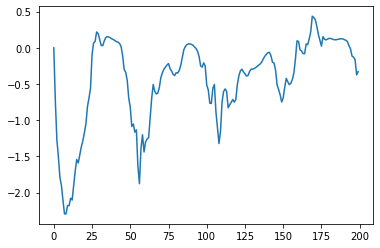

In [ ]:
plt.plot((pred_filter.mean[0] - pred_filter.mean[1]).mean(axis=1).detach().numpy())

[<matplotlib.lines.Line2D>]

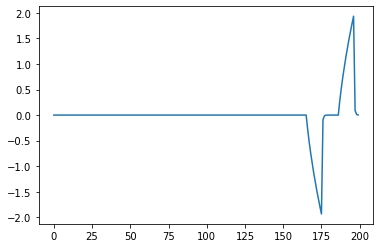

In [ ]:
plt.plot((pred_filter.std[0] - pred_filter.std[1]).mean(axis=1).detach().numpy())

[<matplotlib.lines.Line2D>]

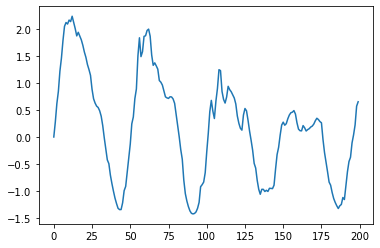

In [ ]:
plt.plot((pred_filter.mean[1] - pred_filter.mean[2]).mean(axis=1).detach().numpy())

with the smoother the data has a bigger impact

[<matplotlib.lines.Line2D>]

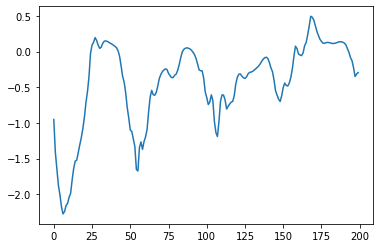

In [ ]:
plt.plot((pred.mean[0] - pred.mean[1]).mean(axis=1).detach().numpy())

[<matplotlib.lines.Line2D>]

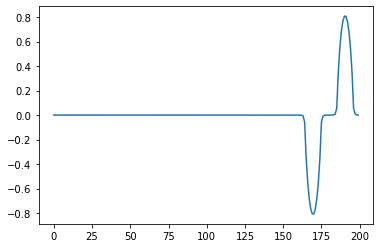

In [ ]:
plt.plot((pred.std[0] - pred.std[1]).mean(axis=1).detach().numpy())

[<matplotlib.lines.Line2D>]

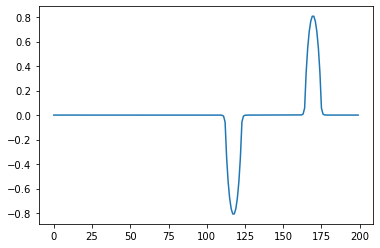

In [ ]:
plt.plot((pred.std[1] - pred.std[2]).mean(axis=1).detach().numpy())

[<matplotlib.lines.Line2D>]

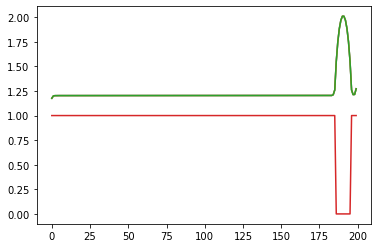

In [ ]:
plt.plot(pred.std[0].detach().numpy())
plt.plot(inputs.mask[0].all(1))

In [ ]:
inputs.mask[0].all(1)

tensor([ True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True,  True,  True,  True, 

In [ ]:
inputs.mask

tensor([[[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]],

        [[True, True, True],
         [True, True, True],
         [True, True, True],
         ...,
         [True, True, True],
         [True, True, True],
         [True, True, True]]])

In [ ]:
model._predict_filter(*dls.one_batch()[0]).mean.shape

torch.Size([3, 200, 3])

In [ ]:
model._predict_filter(*dls.one_batch()[0]).mean

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.9664,  1.5392,  1.2632],
         [ 1.5946,  2.5220,  2.2439],
         ...,
         [ 0.6360,  2.8465,  0.7519],
         [ 0.6607,  2.9757,  0.7987],
         [ 0.7223,  3.1920,  0.9015]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.1998, -0.2805, -0.0618],
         [ 0.3113, -0.3554, -0.1157],
         ...,
         [ 1.1949,  0.2849,  1.4004],
         [ 1.1525,  0.6199,  1.0876],
         [ 1.2526,  0.9968,  1.2575]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.3947, -0.0867, -0.0966],
         [ 0.6618, -0.0530, -0.1112],
         ...,
         [ 1.6150,  3.0145,  2.1963],
         [ 1.6866,  3.0246,  2.5161],
         [ 1.7833,  3.3088,  2.9261]]], grad_fn=<SqueezeBackward1>)

In [ ]:
model._predict_filter(*dls.one_batch()[0])

ListNormal(mean=tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.4572,  0.7817,  0.2992],
         [ 0.6210,  0.8838,  0.2554],
         ...,
         [ 0.8017,  0.0841,  0.0780],
         [ 0.7887,  0.0355, -0.0491],
         [ 0.7525, -0.2149, -0.2159]],

        [[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         ...,
         [-1.3412, -0.5929, -0.7739],
         [-1.3502, -0.5929, -0.7739],
         [-1.3614, -0.5929, -0.7732]],

        [[ 0.0000,  0.0000,  0.0000],
         [-0.1088, -0.2965, -0.2957],
         [-0.2020, -0.4743, -0.4881],
         ...,
         [ 0.2156, -0.5929, -0.6037],
         [ 0.2341, -0.5929, -0.5968],
         [ 0.2537, -0.5929, -0.5827]]], grad_fn=<SqueezeBackward1>), std=tensor([[[1.4142, 1.4142, 1.4142],
         [1.5811, 1.5811, 1.5811],
         [1.6125, 1.6125, 1.6125],
         ...,
         [1.6180, 1.6180, 1.6180],
         [1.6180, 1.6180, 1.6180],
         [1.6180, 1.6180, 1.61

In [ ]:
#| export
@patch
def forward(self: KalmanFilter, masked_data: MaskedTensor):
    data, mask = masked_data
    assert not data.isnan().any()
    use_smooth = self.use_smooth if hasattr(self, 'use_smooth') else True
    
    mean, std = (self.predict(obs=data, mask=mask, smooth=True) if use_smooth
                        else self._predict_filter(data, mask))
    return NormalsParams(mean, std) # to have fastai working this needs to be a tuple subclass

In [ ]:
input = dls.one_batch()[0]
target = dls.one_batch()[1]

In [ ]:
model.state_dict()

OrderedDict([('trans_matrix',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('trans_off', tensor([0., 0., 0.])),
             ('trans_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('obs_matrix',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('obs_off', tensor([0., 0., 0.])),
             ('obs_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]])),
             ('init_state_mean', tensor([0., 0., 0.])),
             ('init_state_cov_raw',
              tensor([[1., 0., 0.],
                      [0., 1., 0.],
                      [0., 0., 1.]]))])

In [ ]:
data = input[0][0]
data.shape

torch.Size([200, 3])

In [ ]:
mask = input[1][0]

In [ ]:
mask.shape

torch.Size([200, 3])

In [ ]:
data.device

device(type='cpu')

In [ ]:
torch.device

torch.device

In [ ]:
data.shape, mask.shape

(torch.Size([200, 3]), torch.Size([200, 3]))

In [ ]:
model.predict(data, mask);

In [ ]:
model.use_smooth = True

In [ ]:
pred = model(input)

In [ ]:
pred[0].shape

torch.Size([10, 200, 3])

In [ ]:
pred[1].shape

torch.Size([10, 200, 3])

In [ ]:
model.use_smooth = False

In [ ]:
pred_filt = model(input)

In [ ]:
pred_filt[1].shape

torch.Size([10, 200, 3])

In [ ]:
pred

__main__.NormalsParams(mean=tensor([[[ 0.4737, -0.0487, -0.2008],
         [ 0.6706, -0.0631, -0.2460],
         [ 0.7475, -0.1832, -0.2590],
         ...,
         [ 0.9275, -0.2909,  0.5635],
         [ 0.9110, -0.4073,  0.5321],
         [ 0.8963, -0.4559,  0.5021]],

        [[ 0.1227, -0.3664, -0.4393],
         [ 0.1795, -0.5064, -0.6033],
         [ 0.2129, -0.5598, -0.6583],
         ...,
         [ 1.4202, -0.5929,  0.2652],
         [ 1.3988, -0.5929,  0.2330],
         [ 1.3636, -0.5929,  0.1535]],

        [[-0.5659, -0.3664, -0.2559],
         [-0.7747, -0.5064, -0.3414],
         [-0.8518, -0.5599, -0.3801],
         ...,
         [-0.9845, -0.5929, -0.7477],
         [-0.9948, -0.5929, -0.7617],
         [-0.9872, -0.5929, -0.7634]],

        ...,

        [[ 0.2619, -0.3649, -0.4030],
         [ 0.3573, -0.5019, -0.5654],
         [ 0.3953, -0.5478, -0.6267],
         ...,
         [ 0.3412, -0.5201, -0.7109],
         [ 0.3391, -0.4359, -0.7046],
         [ 0.3409, -0.

In [ ]:
type(pred), type(pred_filt)

(__main__.NormalsParams, __main__.NormalsParams)

In [ ]:
test_ne(pred, pred_filt)

### Loss Function

add support for complete loss (also outside gap) and for filter loss (don't run the smooher)

There are two ways to compute the loss, one is to do it for all predictions the other is for doing it for only the gap
- only_gap

Play around with flatting + diagonal

In [ ]:
a = torch.diag(torch.tensor([1,2,3]))
d = torch.stack([a, a*10])
m = torch.stack([a.diag(), a.diag()*10])
d

tensor([[[ 1,  0,  0],
         [ 0,  2,  0],
         [ 0,  0,  3]],

        [[10,  0,  0],
         [ 0, 20,  0],
         [ 0,  0, 30]]])

In [ ]:
m.flatten()

tensor([ 1,  2,  3, 10, 20, 30])

In [ ]:
d

tensor([[[ 1,  0,  0],
         [ 0,  2,  0],
         [ 0,  0,  3]],

        [[10,  0,  0],
         [ 0, 20,  0],
         [ 0,  0, 30]]])

In [ ]:
torch.diagonal(d, dim1=1, dim2=2).flatten()

tensor([ 1,  2,  3, 10, 20, 30])

In [ ]:
means, stds = pred
data, mask = target

In [ ]:
# make a big matrix with all variables and observations and compute ll
mask = mask.flatten() 
obs = data.flatten()[mask]
means = data.flatten()[mask]
stds = stds.flatten()[mask] # need to support batches

MultivariateNormal(means, torch.diag(stds)).log_prob(obs)

tensor(-5929.3633, grad_fn=<SubBackward0>)

In [ ]:
#| export
class KalmanLoss():
    def __init__(self,
                 only_gap:bool=True, # loss for all predictions or only gap
                 reduction:str='sum' # one of ['sum', 'mean', 'none']
                ):
        store_attr()
    
    def __call__(self, pred: NormalsParams, target: MaskedTensor):
        data, mask = target
        means, stds = pred        
        assert not stds.isnan().any()
        losses = torch.empty(data.shape[0], device=data.device, dtype=data.dtype)
        for i, (d, m, mean, std) in enumerate(zip(data, mask, means, stds)):
            losses[i] = self._loss_batch(d,m,mean, std)
        if self.reduction == 'none': return losses
        elif self.reduction == 'mean': return losses.mean()
        elif self.reduction == 'sum': return losses.sum()
    
    def _loss_batch(self, data, mask, mean, std):
        # make a big vector with all variables and observations and compute ll
        mask = mask.flatten() if self.only_gap else torch.fill(mask, True).flatten()
        obs = data.flatten()[mask]
        mean = data.flatten()[mask]
        std = std.flatten()[mask] 
        
        return MultivariateNormal(mean, torch.diag(std)).log_prob(obs)
        

In [ ]:
means, stds = pred

In [ ]:
stds.shape

torch.Size([10, 200, 3])

In [ ]:
means.shape

torch.Size([10, 200, 3])

In [ ]:
data.isnan().any()

tensor(False)

In [ ]:
mask.isnan().any()

tensor(False)

In [ ]:
means.isnan().any()

tensor(False)

In [ ]:
stds.isnan().sum()

tensor(0)

In [ ]:
stds

tensor([[[1.1756, 1.1756, 1.1756],
         [1.1990, 1.1990, 1.1990],
         [1.2024, 1.2024, 1.2024],
         ...,
         [1.2045, 1.2045, 1.2045],
         [1.2133, 1.2133, 1.2133],
         [1.2720, 1.2720, 1.2720]],

        [[1.1756, 1.1756, 1.1756],
         [1.1990, 1.1990, 1.1990],
         [1.2024, 1.2024, 1.2024],
         ...,
         [1.2045, 1.2045, 1.2045],
         [1.2133, 1.2133, 1.2133],
         [1.2720, 1.2720, 1.2720]],

        [[1.1756, 1.1756, 1.1756],
         [1.1990, 1.1990, 1.1990],
         [1.2024, 1.2024, 1.2024],
         ...,
         [1.2045, 1.2045, 1.2045],
         [1.2133, 1.2133, 1.2133],
         [1.2720, 1.2720, 1.2720]],

        ...,

        [[1.1756, 1.1756, 1.1756],
         [1.1990, 1.1990, 1.1990],
         [1.2024, 1.2024, 1.2024],
         ...,
         [1.2045, 1.2045, 1.2045],
         [1.2133, 1.2133, 1.2133],
         [1.2720, 1.2720, 1.2720]],

        [[1.1756, 1.1756, 1.1756],
         [1.1990, 1.1990, 1.1990],
         [1.

In [ ]:
is_posdef_eigv(torch.diag(stds.flatten()))

(tensor(True),
 tensor([1.1756, 1.1756, 1.1756,  ..., 2.0096, 2.0096, 2.0096],
        grad_fn=<LinalgEighBackward0>))

In [ ]:
KalmanLoss(only_gap=True)(pred, target)

tensor(-5929.3633, grad_fn=<SumBackward0>)

In [ ]:
KalmanLoss(only_gap=False)(pred, target)

tensor(-6132.7690, grad_fn=<SumBackward0>)

### Metrics

Wrapper around fastai metrics to support masked tensors and normal distributions

In [ ]:
#| export
def to_msk_metric(metric, name):
    def msk_metric(imp, targ):
        return metric(imp[0], targ[0]) # first element are the means
    msk_metric.__name__ = name
    return msk_metric

In [ ]:
from fastai.metrics import *

In [ ]:
msk_rmse = to_msk_metric(rmse, 'rmse')

In [ ]:
msk_rmse.__name__

'rmse'

In [ ]:
msk_rmse(pred, target)

TensorBase(1.1492)

In [ ]:
msk_r2 = to_msk_metric(R2Score(), 'r2')

In [ ]:
msk_r2(pred, target)

-1.2005627677868254

### Callback

save the model state 

In [ ]:
#| export
from fastai.callback.all import *

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
#| export
class SaveParams(Callback):
    def __init__(self, param_name):
        super().__init__()
        self.params = []
        self.param_name = param_name
    def after_batch(self):
        param = getattr(self.model, self.param_name).detach()
        self.params.append(param)

In [ ]:
debug_preds = []

In [ ]:
class DebugPredCallback(Callback):
    order = 0
    def after_validate(self):
        if hasattr(self, 'gather_preds'):
            debug_preds.append(self.gather_preds.preds)

### Learner

In [ ]:
#| export
from fastai.learner import * 

from fastai.tabular.all import *

from fastai.tabular.learner import *

from fastai.callback.progress import ShowGraphCallback

In [ ]:
obs_cov_history = SaveParams('obs_cov')

In [ ]:
all_data = CollectDataCallback()

In [ ]:
model = KalmanFilter.init_random(n_dim_obs = hai.shape[1], n_dim_state = hai.shape[1]).cuda()

In [ ]:
model.use_smooth = False

In [ ]:
# model._set_constraint('obs_cov', model.obs_cov, train=False)

In [ ]:
pipeline, block_ids = imp_pipeline(hai[:20000], block_len, gap_len)
    
splits = RandomSplitter()(block_ids)
ds = Datasets(block_ids, [pipeline + [to_tuple], pipeline + [to_tuple]], splits=splits)

In [ ]:
dls = ds.dataloaders(bs=10, device='cuda')

In [ ]:
dls.one_batch()[0][0].device

device(type='cuda', index=0)

In [ ]:
input, target = dls.one_batch()
pred = model(input)
KalmanLoss()(pred, target)

tensor(-305.7042, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
learn = Learner(dls, model, loss_func=KalmanLoss(only_gap=False), cbs = [DebugPredCallback] , metrics = [msk_rmse, msk_r2])

In [ ]:
learn.fit(1, 1e-3)

epoch,train_loss,valid_loss,rmse,r2,time
0,-419.399567,-440.761749,3.342487,-13.898747,00:08


In [ ]:
GatherPredsCallback().name

'gather_preds'

In [ ]:
pred = learn.get_preds(with_targs=False, with_decoded=True)

In [ ]:
len(tuplify(pred[2]))

2

In [ ]:
learn.dls.test_dl([1]).one_batch()

((tensor([[[-1.1405, -0.5702, -0.7476],
           [-1.1405, -0.5702, -0.7520],
           [-1.1391, -0.5702, -0.7586],
           [-1.1419, -0.5702, -0.7674],
           [-1.1405, -0.5702, -0.7735],
           [-1.1391, -0.5702, -0.7784],
           [-1.1349, -0.5678, -0.7812],
           [-1.1279, -0.5506, -0.7828],
           [-1.1125, -0.5319, -0.7839],
           [-1.1026, -0.5056, -0.7839]]], device='cuda:0'),
  tensor([[[ True,  True,  True],
           [False, False,  True],
           [False, False,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True],
           [ True,  True,  True]]], device='cuda:0')),)

In [ ]:
dl = dls.test_dl([1,2], with_labels=True)

In [ ]:
learn.get_preds(dl=dl, with_targs=True, with_loss=True)

(__main__.NormalsParams(mean=tensor([[[ 1.0845,  1.5834,  0.5826],
          [-2.0406, -1.5340, -0.6335],
          [-2.0107, -1.3459, -0.6058],
          [-1.9418, -1.2663, -0.5702],
          [-1.9313, -1.2526, -0.5650],
          [-2.5698, -2.0371, -0.8713],
          [-4.2385, -3.7844, -1.6032],
          [-1.9990, -1.4044, -0.6044],
          [-1.9074, -1.2301, -0.5556],
          [-1.8488, -1.1662, -0.5286]],
 
         [[ 1.0845,  1.5834,  0.5826],
          [-1.8904, -1.3707, -0.5664],
          [-1.8062, -1.1233, -0.5136],
          [-1.6458, -0.9289, -0.4334],
          [-1.7084, -1.0170, -0.4653],
          [-1.7076, -1.0232, -0.4669],
          [-2.0386, -1.4971, -0.6416],
          [-2.9869, -2.5162, -1.0628],
          [-1.7457, -1.1439, -0.4935],
          [-1.6724, -0.9925, -0.4532]]]), std=tensor([[[ 2.9874,  2.9823,  1.7969],
          [ 2.6119,  2.6208,  1.7767],
          [ 2.6634,  2.7117,  1.7933],
          [ 2.6638,  2.7120,  1.7934],
          [ 2.6638,  2.7120

In [ ]:
item = 1
dl = learn.dls.test_dl([item],num_workers=0)
inp,preds,_,dec_preds = learn.get_preds(dl=dl, with_input=True, with_decoded=True)
i = getattr(learn.dls, 'n_inp', -1)

In [ ]:
dl.one_batch()[0]

(tensor([[[-1.1405, -0.5702, -0.7476],
          [-1.1405, -0.5702, -0.7520],
          [-1.1391, -0.5702, -0.7586],
          [-1.1419, -0.5702, -0.7674],
          [-1.1405, -0.5702, -0.7735],
          [-1.1391, -0.5702, -0.7784],
          [-1.1349, -0.5678, -0.7812],
          [-1.1279, -0.5506, -0.7828],
          [-1.1125, -0.5319, -0.7839],
          [-1.1026, -0.5056, -0.7839]]], device='cuda:0'),
 tensor([[[ True,  True,  True],
          [ True,  True,  True],
          [False, False,  True],
          [False, False,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True],
          [ True,  True,  True]]], device='cuda:0'))

In [ ]:
a,b = learn.get_preds(dl=dl)

In [ ]:
list(TfmdLists([0,1], learn.dls.fs[0][0,1]))

[__main__.MaskedDf(data=                       TA  SW_IN    VPD
 time                                   
 2000-01-01 00:30:00 -0.60    0.0  0.222
 2000-01-01 01:00:00 -0.65    0.0  0.122
 2000-01-01 01:30:00 -0.58    0.0  0.090
 2000-01-01 02:00:00 -0.51    0.0  0.110
 2000-01-01 02:30:00 -0.49    0.0  0.102
 2000-01-01 03:00:00 -0.40    0.0  0.111
 2000-01-01 03:30:00 -0.36    0.0  0.109
 2000-01-01 04:00:00 -0.35    0.0  0.107
 2000-01-01 04:30:00 -0.28    0.0  0.122
 2000-01-01 05:00:00 -0.27    0.0  0.138, mask=                        TA  SW_IN   VPD
 time                                   
 2000-01-01 00:30:00   True   True  True
 2000-01-01 01:00:00   True   True  True
 2000-01-01 01:30:00   True   True  True
 2000-01-01 02:00:00   True   True  True
 2000-01-01 02:30:00   True   True  True
 2000-01-01 03:00:00  False  False  True
 2000-01-01 03:30:00  False  False  True
 2000-01-01 04:00:00   True   True  True
 2000-01-01 04:30:00   True   True  True
 2000-01-01 05:00:00   True  

### Predictions

In [ ]:
#| export
class NormalsDf:
    """DataFrames of Normal parameters (mean and std)"""
    def __init__(self, mean, std): store_attr()
    def tidy(self, prefix=""):
        """Tidy version"""
        mean = self.mean.reset_index().melt("time", value_name=prefix + "mean")
        std = self.std.reset_index().melt("time", value_name=prefix + "std")
        return pd.merge(mean, std, on=["time", "variable"])
    __repr__ = basic_repr("mean, std")

In [ ]:
from nbdev import show_doc

is in this in the wrong order?????

In [ ]:
def custom_predict(learn, items):
    dl = learn.dls.test_dl(items, with_labels = True, num_workers=0)
    targs = list(TfmdLists(items, learn.dls.fs[0][0,1])) # don't need to decoded them after 
    preds, _, loss = learn.get_preds(dl=dl, with_loss=True)
    # denormalize predictions
    preds = learn.dls.fs[0][-2].decode(preds)
    # return preds, targs, loss
    return preds2df(preds, targs), targs, loss

In [ ]:
def preds_items(items):
    dl = learn.dls.test_dl(items, with_labels = True, num_workers=0)
    preds, _, loss = learn.get_preds(dl=dl, with_loss=True)
    return preds

In [ ]:
input = learn.dls.test_dl(items, with_labels = True, num_workers=0).one_batch()[0]

In [ ]:
preds_items([0]).mean - preds_items([0]).mean

tensor([[[ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.0000,  0.0000,  0.0000],
         [ 0.7252,  0.8758,  0.3443],
         [ 2.5638,  2.7951,  1.1497],
         [-0.5833, -0.6469, -0.2725],
         [-2.4119, -2.6355, -1.0821]]])

In [ ]:
test_close(learn.model(input).mean, learn.model(input).mean)

In [ ]:
preds_items([0])

__main__.NormalsParams(mean=tensor([[[ 1.0845,  1.5834,  0.5826],
         [-2.1368, -1.6244, -0.6735],
         [-2.1112, -1.4332, -0.6464],
         [-2.0226, -1.3335, -0.6023],
         [-1.9934, -1.3043, -0.5897],
         [-1.9881, -1.3006, -0.5876],
         [-2.6924, -2.1574, -0.9234],
         [-4.5224, -4.0704, -1.7255],
         [-2.0450, -1.4475, -0.6236],
         [-1.9620, -1.2853, -0.5795]]]), std=tensor([[[ 2.9874,  2.9823,  1.7969],
         [ 2.6119,  2.6208,  1.7767],
         [ 2.6634,  2.7117,  1.7933],
         [ 2.6638,  2.7120,  1.7934],
         [ 2.6638,  2.7120,  1.7934],
         [ 2.6638,  2.7120,  1.7934],
         [ 6.7237,  6.9196,  3.2179],
         [16.0926, 16.3718,  7.0920],
         [ 2.6622,  2.7148,  1.7932],
         [ 2.6641,  2.7124,  1.7935]]]))

In [ ]:
preds, targs, losses = custom_predict(learn, [0,110,200])

decoding


In [ ]:
preds[1].mean

,TA,SW_IN,VPD
time,,,
2000-01-23 22:30:00,21.271610,565.400269,6.531728
2000-01-23 23:00:00,18.597784,496.855865,6.458384
2000-01-23 23:30:00,18.964550,514.089478,6.518624
2000-01-24 00:00:00,18.967861,514.141602,6.519216
2000-01-24 00:30:00,18.967855,514.140808,6.519212
2000-01-24 01:00:00,18.967848,514.140747,6.519211
2000-01-24 01:30:00,18.967836,514.140381,6.519209
2000-01-24 02:00:00,47.876350,1311.831665,11.697318
2000-01-24 02:30:00,114.587265,3103.807617,25.779840


In [ ]:
preds[0].mean.to_numpy() - preds[1].mean.to_numpy()

array([[-5.6584826e+00, -1.5712631e+02, -1.5584517e+00],
       [-2.5921778e+01, -6.9673059e+02, -6.0508251e+00],
       [-2.6105961e+01, -6.7771338e+02, -6.0127811e+00],
       [-2.5478497e+01, -6.5886072e+02, -5.8529940e+00],
       [-2.5270941e+01, -6.5331506e+02, -5.8073034e+00],
       [-2.5233042e+01, -6.5262305e+02, -5.7996802e+00],
       [-2.5083574e+01, -6.4902661e+02, -5.7687454e+00],
       [-5.8824921e+01, -1.6040135e+03, -1.2126036e+01],
       [-1.3812679e+02, -3.7466855e+03, -2.9026869e+01],
       [-2.5544104e+01, -6.7928162e+02, -5.9111185e+00]], dtype=float32)

In [ ]:
tfms_targs, tfms

NameError: name 'tfms_targs' is not defined

In [ ]:
tfms4(0).mask == tfms4(0).mask

tensor([[ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [False, False,  True],
        [ True,  True,  True],
        [ True,  True,  True],
        [ True,  True,  True]])

This was an Horrible idea!!!!!

In [ ]:
pipe0, pipe1 = tfms4.fs[0,1], tfms4.fs[2,3] 

In [ ]:
pipe0, pipe1

((#2) [BlockDfTransform:
encodes: (int,object) -> encodes
decodes: ,AddGapTransform:
encodes: (DataFrame,object) -> encodes
decodes: ],
 (#2) [MaskedDf2Tensor:
encodes: (MaskedDf,object) -> encodes
decodes: (MaskedTensor,object) -> decodes
,NormalizeMasked -- {'mean': tensor([  8.3339, 120.9578,   3.3807]), 'std': tensor([  7.9246, 204.0026,   4.3684])}:
encodes: (MaskedTensor,object) -> encodes
decodes: (MaskedTensor,object) -> decodes
(NormalsParams,object) -> decodes
])

In [ ]:
item = 1

In [ ]:
def preds2df(preds, targs):
    """Final step to decode preds by getting a dataframe"""
    # preds this is a tuple (data, mask)
    out = []
    for pred, targ in zip(preds, targs):
        # convert to dataframe using structure for
        mean = pd.DataFrame(pred[0].squeeze(0).detach().cpu().numpy(), columns = targ.data.columns, index=targ.data.index)
        std = pd.DataFrame(pred[1].squeeze(0).detach().cpu().numpy(), columns = targ.data.columns, index=targ.data.index)
        out.append(NormalsDf(mean, std))
    return out

In [ ]:
def predict_items(items, learn, pipe0, pipe1):
    pipe0, pipe1 = Pipeline(pipe0), Pipeline(pipe1)
    preds, targs, losses = [], [], []
    for item in items:
        targ = pipe0(item)
        data, mask = pipe1(targ)
        input = MaskedTensor(data.cuda().unsqueeze(0), mask.cuda().unsqueeze(0))
        pred = model(input)
        loss = learn.loss_func(pred, input)
        # denormalize
        pred = pipe1.decode(pred)
        preds.append(pred), targs.append(targ), losses.append(loss)
        
    return preds2df(preds, targs), targs, losses
        

In [ ]:
preds, targs, losses = predict_items([0,1,3], learn, pipe0, pipe1)

decoding
decoding
decoding


this is the same dataaaaaa

In [ ]:
predict_items([0], learn, pipe0, pipe1)[1][0].data == predict_items([0], learn, pipe0, pipe1)[1][0].data

decoding
decoding


,TA,SW_IN,VPD
time,,,
2000-01-01 00:30:00,True,True,True
2000-01-01 01:00:00,True,True,True
2000-01-01 01:30:00,True,True,True
2000-01-01 02:00:00,True,True,True
2000-01-01 02:30:00,True,True,True
2000-01-01 03:00:00,True,True,True
2000-01-01 03:30:00,True,True,True
2000-01-01 04:00:00,True,True,True
2000-01-01 04:30:00,True,True,True


In [ ]:
preds[0][0]

tensor([[[ 1.6928e+01,  4.4397e+02,  5.9255e+00],
         [-7.8420e+00, -1.9373e+02,  6.0494e-01],
         [-7.6738e+00, -1.5710e+02,  7.0982e-01],
         [-7.0250e+00, -1.3825e+02,  8.8854e-01],
         [-6.8115e+00, -1.3269e+02,  9.3944e-01],
         [-1.1764e+01, -2.8860e+02, -3.6598e-01],
         [-2.4670e+01, -6.3621e+02, -3.4856e+00],
         [-7.2074e+00, -1.6005e+02,  7.9891e-01],
         [-6.7074e+00, -1.3211e+02,  9.5261e-01],
         [-6.4650e+00, -1.2542e+02,  1.0145e+00]]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [ ]:
loss

tensor(-44.1597, device='cuda:0', grad_fn=<SumBackward0>)

In [ ]:
pred.mean.shape

torch.Size([1, 10, 3])

In [ ]:
pred.std.shape

torch.Size([1, 10, 3])

In [ ]:
targs, input

(__main__.MaskedDf(data=                       TA  SW_IN    VPD
 time                                   
 2000-01-01 05:30:00 -0.23   0.00  0.138
 2000-01-01 06:00:00 -0.23   0.00  0.122
 2000-01-01 06:30:00 -0.22   0.00  0.098
 2000-01-01 07:00:00 -0.24   0.00  0.066
 2000-01-01 07:30:00 -0.23   0.00  0.044
 2000-01-01 08:00:00 -0.22   0.00  0.026
 2000-01-01 08:30:00 -0.19   0.45  0.016
 2000-01-01 09:00:00 -0.14   3.70  0.010
 2000-01-01 09:30:00 -0.03   7.26  0.006
 2000-01-01 10:00:00  0.04  12.24  0.006, mask=                        TA  SW_IN   VPD
 time                                   
 2000-01-01 05:30:00   True   True  True
 2000-01-01 06:00:00   True   True  True
 2000-01-01 06:30:00   True   True  True
 2000-01-01 07:00:00  False  False  True
 2000-01-01 07:30:00  False  False  True
 2000-01-01 08:00:00   True   True  True
 2000-01-01 08:30:00   True   True  True
 2000-01-01 09:00:00   True   True  True
 2000-01-01 09:30:00   True   True  True
 2000-01-01 10:00:00   True  

In [ ]:
fa_collate??

Signature: fa_collate(t)
Source:   
def fa_collate(t):
    "A replacement for PyTorch `default_collate` which maintains types and handles `Sequence`s"
    b = t[0]
    return (default_collate(t) if isinstance(b, _collate_types)
            else type(t[0])([fa_collate(s) for s in zip(*t)]) if isinstance(b, Sequence)
            else default_collate(t))
File:      ~/anaconda3/envs/data-science/lib/python3.10/site-packages/fastai/data/load.py
Type:      function


In [ ]:
def custom_predict2(learn, items):
    targs = list(TfmdLists(items, learn.dls.fs[1][0,1])) # no need to decode
    dl = learn.dls.test_dl(items, with_labels=True, num_workers=0)
    inputs, loss_targs = dl.one_batch() 
    preds = learn.model(inputs)
    with learn.loss_not_reduced():
        losses = learn.loss_func(preds, loss_targs)
    
    preds = learn.dls.fs[0][-2].decode(preds)
    return preds, loss
    return preds2df(preds, targs), targs, losses

In [ ]:
preds, targs, losses = custom_predict2(learn, [0,110,200])

decoding


In [ ]:
items = [1,100]

In [ ]:
inputs, loss_targs = dl.one_batch()

In [ ]:
learn.model(inputs)

__main__.NormalsParams(mean=tensor([[[-1.7114, -0.8861, -1.2593],
         [-1.1359, -0.5130, -2.0515],
         [-0.5994, -0.5551, -1.4270],
         [-1.2965, -0.7579, -0.9387],
         [-1.5294, -0.7284, -1.2223],
         [-1.4666, -0.7303, -1.1573],
         [-1.4804, -0.7346, -1.1799],
         [-1.4842, -0.7376, -1.1964],
         [-1.5438, -0.7937, -1.2960],
         [-1.7521, -0.9268, -1.5685]],

        [[-2.4304, -0.8768, -1.5493],
         [-1.6591, -0.6981, -0.6923],
         [-1.5964, -0.6694, -0.6369],
         [-1.6627, -0.7449, -0.7344],
         [-1.8259, -0.8049, -0.8953],
         [-0.9698, -0.3807, -1.8680],
         [-0.4263, -0.5096, -1.2325],
         [-1.4205, -0.7730, -0.5457],
         [-1.8093, -0.8115, -1.1088],
         [-1.9225, -0.9265, -1.2887]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>), std=tensor([[[1.2225, 1.1840, 1.6276],
         [1.5016, 1.2724, 2.0035],
         [1.4686, 1.2079, 1.9739],
         [1.2554, 1.1582, 1.6938],
         [1

In [ ]:
custom_predict2(learn, [1,100])

__main__.NormalsParams(mean=tensor([[[-1.5372, -0.7658, -1.0604],
         [-1.5186, -0.7225, -1.1955],
         [-1.4665, -0.7288, -1.1409],
         [-1.4799, -0.7291, -1.1611],
         [-1.5297, -0.7777, -1.2348],
         [-1.6486, -0.8343, -1.3761],
         [-1.0602, -0.5132, -1.9576],
         [-0.6387, -0.5718, -1.4714],
         [-1.3740, -0.8243, -1.0856],
         [-1.7910, -0.9128, -1.6092]],

        [[-2.4331, -0.8792, -1.5528],
         [-1.6594, -0.6962, -0.6937],
         [-1.6795, -0.7467, -0.7479],
         [-1.8170, -0.8012, -0.9061],
         [-0.9426, -0.3630, -1.8333],
         [-0.3904, -0.4925, -1.1905],
         [-1.4118, -0.7552, -0.4231],
         [-1.7220, -0.7194, -0.9124],
         [-1.7146, -0.8121, -1.0015],
         [-1.9293, -0.9189, -1.2938]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>), std=tensor([[[1.1830, 1.1499, 1.5739],
         [1.2342, 1.1559, 1.6685],
         [1.2358, 1.1561, 1.6704],
         [1.2359, 1.1562, 1.6705],
         [1

In [ ]:
targs = list(TfmdLists(items, learn.dls.fs[1][0,1])) # no need to decode
dl = learn.dls.test_dl(items, with_labels=True, num_workers=0)
inputs, loss_targs = dl.one_batch() 

In [ ]:
learn.model.predict(inputs[0][0], inputs[1][0])

ListNormal(mean=tensor([[[-1.0498, -0.6091, -0.6871],
         [-1.0529, -0.5194, -1.0048],
         [-1.2414, -0.7677, -1.2048]],

        [[-1.0498, -0.6091, -0.6871],
         [-1.0533, -0.5198, -1.0054],
         [-1.2448, -0.7702, -1.2080]],

        [[-1.0490, -0.6088, -0.6864],
         [-1.0537, -0.5203, -1.0060],
         [-1.2500, -0.7739, -1.2128]],

        [[-1.0507, -0.6094, -0.6878],
         [-1.0550, -0.5211, -1.0078],
         [-1.2569, -0.7789, -1.2193]],

        [[-1.0499, -0.6091, -0.6871],
         [-1.0553, -0.5216, -1.0083],
         [-1.2616, -0.7822, -1.2236]],

        [[-1.0490, -0.6088, -0.6864],
         [-1.0556, -0.5220, -1.0087],
         [-1.2654, -0.7850, -1.2272]],

        [[-1.0462, -0.6076, -0.6841],
         [-1.0543, -0.5216, -1.0079],
         [-1.2672, -0.7865, -1.2287]],

        [[-0.3913, -0.3265, -0.1204],
         [-0.5732, -0.3722, -1.3540],
         [-1.1949, -0.8926, -1.1536]],

        [[-0.3913, -0.3266, -0.1205],
         [-0.5734,

In [ ]:
model.use_smooth = True

In [ ]:
learn.model(inputs)

__main__.NormalsParams(mean=tensor([[[-1.5372, -0.7658, -1.0604],
         [-1.5186, -0.7225, -1.1955],
         [-1.4665, -0.7288, -1.1409],
         [-1.4799, -0.7291, -1.1611],
         [-1.5297, -0.7777, -1.2348],
         [-1.6486, -0.8343, -1.3761],
         [-1.0602, -0.5132, -1.9576],
         [-0.6387, -0.5718, -1.4714],
         [-1.3740, -0.8243, -1.0856],
         [-1.7910, -0.9128, -1.6092]],

        [[-2.4304, -0.8769, -1.5493],
         [-1.6565, -0.6957, -0.6889],
         [-1.5933, -0.6688, -0.6319],
         [-1.5795, -0.6699, -0.6223],
         [-1.5885, -0.6710, -0.6123],
         [-1.6823, -0.7548, -0.7520],
         [-1.8588, -0.8315, -0.9737],
         [-1.0878, -0.4684, -2.0227],
         [-0.6853, -0.6717, -1.5725],
         [-1.9326, -1.1321, -1.3170]]], device='cuda:0',
       grad_fn=<SqueezeBackward1>), std=tensor([[[1.1830, 1.1499, 1.5739],
         [1.2342, 1.1559, 1.6685],
         [1.2358, 1.1561, 1.6704],
         [1.2359, 1.1562, 1.6705],
         [1

In [ ]:
dl = learn.dls.test_dl(items,with_labels=True, num_workers=0)

NameError: name 'items' is not defined

In [ ]:
preds, _, loss = learn.get_preds(dl=dl, with_loss=True)

In [ ]:
preds

In [ ]:
dls.test_dl??

In [ ]:
items = [0, 800]

In [ ]:
test_ds = test_set(dls.valid_ds, items) if isinstance(dls.valid_ds, (Datasets, TfmdLists)) else test_items

In [ ]:
dls.valid.new(test_ds).one_batch()

In [ ]:
dls.valid.new??

In [ ]:
learn.dls.test_dl([0, 800],with_labels=True, num_workers=0).one_batch()

In [ ]:
custom_predict(learn, 0)

In [ ]:
preds, targs, loss = custom_predict(learn, 1)
preds[0], targs[0], loss

#### Show results

In [ ]:
def plot_result(pred, targ, loss, **kwargs):
    df = pd.merge(targ.tidy(), pred.tidy(), on=["time", "variable"])
    return facet_variable(df, error=True, **kwargs).properties(title=f"loss: {loss.item():.6f}")

In [ ]:
plot_result(preds[0], targs[0], torch.tensor(1))

alt.VConcatChart(...)

In [ ]:
def plot_results(preds, targs, losses):
    plots = [plot_result(targ, pred, loss, n_cols=1) for targ, pred, loss in zip(preds, targs, losses)]
    return alt.hconcat(*plots)

In [ ]:
plot_results(preds, targs, losses)

alt.HConcatChart(...)

In [ ]:
random.choices(learn.dls.items, k=3)

[1590, 438, 1980]

In [ ]:
def show_results(learn, n=3):
    items = random.choices(learn.dls.items, k=3)
    pipe0, pipe1 = learn.dls.fs[0][0,1], learn.dls.fs[0][2,3]
    return plot_results(*predict_items(items, learn, pipe0, pipe1))
    

In [ ]:
show_results(learn)

decoding
decoding
decoding


alt.HConcatChart(...)

In [ ]:
dls.one_batch()[0][0].shape

torch.Size([10, 10, 3])

In [ ]:
plot_results(*custom_predict(learn, [2,3]))

decoding


alt.HConcatChart(...)

In [ ]:
preds[0].std

,TA,SW_IN,VPD
time,,,
2000-01-01 00:30:00,21.271610,565.400269,6.531728
2000-01-01 01:00:00,18.597784,496.855865,6.458384
2000-01-01 01:30:00,46.829216,1281.956299,11.480843
2000-01-01 02:00:00,112.070724,3035.359375,25.233408
2000-01-01 02:30:00,19.019865,516.365479,6.527177
2000-01-01 03:00:00,18.969639,514.225403,6.519597
2000-01-01 03:30:00,18.968021,514.146973,6.519240
2000-01-01 04:00:00,18.967875,514.141479,6.519215
2000-01-01 04:30:00,18.967861,514.140991,6.519213


In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
preds[1].std

,TA,SW_IN,VPD
time,,,
2000-01-23 22:30:00,21.271610,565.400269,6.531728
2000-01-23 23:00:00,18.597784,496.855865,6.458384
2000-01-23 23:30:00,46.829216,1281.956299,11.480843
2000-01-24 00:00:00,112.070724,3035.359375,25.233408
2000-01-24 00:30:00,19.019865,516.365479,6.527177
2000-01-24 01:00:00,18.969639,514.225403,6.519597
2000-01-24 01:30:00,18.968021,514.146973,6.519240
2000-01-24 02:00:00,18.967875,514.141479,6.519215
2000-01-24 02:30:00,18.967861,514.140991,6.519213


In [ ]:
plot_results(preds, targs, losses)

alt.HConcatChart(...)

In [ ]:
def show_results(items):
    plots = [plot_result(targ, pred, loss, n_cols=1) for targ, pred, loss in custom_predict(learn, item) for item in items]
    return alt.hconcat(*plots)

In [ ]:
show_results(items=[0])

In [ ]:
len(targs)

In [ ]:
learn.dls.fs[0][-2].decode(preds)

In [ ]:
tfms4.fs[0].encodes([1,2])

In [ ]:
decode_preds(targs, [1,2,3])

In [ ]:
preds

In [ ]:
batch_to_samples(preds)[0]

In [ ]:
dl._decode_batch??

In [ ]:
tfms4.decode(MaskedTensor(targs))

In [ ]:
tfms4.decode(tfms4[0])

In [ ]:
b

In [ ]:
preds

this is not really working as intended .... so mnaully rebuilding the decoding pipeline

In [ ]:
dls.decode((preds,))

In [ ]:
norm

In [ ]:
preds[1] * norm.std

In [ ]:
tfms4.decode(preds)

In [ ]:
learn.get_preds()

In [ ]:
len([*learn.yb])

In [ ]:
learn.get_preds(dl=dl, with_targs=True)

In [ ]:
dl.one_batch()

In [ ]:
%debug

In [ ]:
learn._do_one_batch??

In [ ]:
dls.test_dl??

In [ ]:
dls

In [ ]:
dl.one_batch()

In [ ]:
%debug

In [ ]:
custom_predict(learn, [1,2], tfms4)

In [ ]:
def show_results(preds, targets):

In [ ]:
ii = inp + tuplify(dec_preds)

In [ ]:
is_listy(ii)

In [ ]:
dec = learn.dls.decode_batch(ii)[0]

In [ ]:
%debug

In [ ]:
dls._types[tuple]

In [ ]:
typs = dls._types

In [ ]:
t = first(typs.keys())
typs = typs[t]

In [ ]:
def debug(new, old, typ):
    print(is_listy(new))
    print(typ)

In [ ]:
L(ii, None, typs).map_zip(debug, cycled=True)

In [ ]:
ii[0]

In [ ]:
len(ii)

In [ ]:
typs

In [ ]:
L(ii, )

In [ ]:
learn.dls._retain_dl??

In [ ]:
retain_types??

In [ ]:
is_listy(ii)

In [ ]:
retain_type??

In [ ]:
learn.dls.decode(ii)

In [ ]:
learn.dls._decode_batch??

In [ ]:
inp = (inp,) if i==1 else tuplify(inp)

In [ ]:
dec = learn.dls.decode_batch(inp + tuplify(dec_preds))[0]

In [ ]:
dec_preds

In [ ]:
learn.predict(1)

In [ ]:
pred

In [ ]:
dls.decode

In [ ]:
dls.train._retain_dl??

In [ ]:
dls.after_batch??

In [ ]:
dls._one_pass()

In [ ]:
dls._types

In [ ]:
dls.decode(pred[0])

In [ ]:
%debug

In [ ]:
dls._types

In [ ]:
preds = learn.get_preds(with_decoded=True)

In [ ]:
preds[0].mean.shape

In [ ]:
preds[0].mean

In [ ]:
learn.show_results()

In [ ]:
tfms4[0]

In [ ]:
dls.decode(to_tuple(tfms4[0]))

In [ ]:
learn.predict(tfms4[0])

In [ ]:
len(preds)

In [ ]:
type(preds[1])

In [ ]:
def gen():
    for i in range(3):
        yield i

In [ ]:
isinstance(gen(), Generator)

In [ ]:
list((1,2,))

In [ ]:
tuple(gen())

In [ ]:
nested_reorder??

In [ ]:
type(preds[0][0])

In [ ]:
xs = preds[0][0]

In [ ]:
def to_concat(xs, dim=0):
    "Concat the element in `xs` (recursively if they are tuples/lists of tensors)"
    if not xs: return xs
    if is_listy(xs[0]): return type(xs[0])([to_concat([x[i] for x in xs], dim=dim) for i in range_of(xs[0])])
    if isinstance(xs[0],dict):  return {k: to_concat([x[k] for x in xs], dim=dim) for k in xs[0].keys()}
    #We may receive xs that are not concatenable (inputs of a text classifier for instance),
    #   in this case we return a big list
    try:    return retain_type(torch.cat(xs, dim=dim), xs[0])
    except: return sum([L(retain_type(o_.index_select(dim, tensor(i)).squeeze(dim), xs[0])
                          for i in range_of(o_)) for o_ in xs], L())

In [ ]:
to_concat(xs)

In [ ]:
xs.__len__()

In [ ]:
bool(xs)

In [ ]:
is_coll??

In [ ]:
learn.gather_preds

In [ ]:
learn.model.state_dict()

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
to_concat??

In [ ]:
is_listy??

In [ ]:
is_listy(pred)

In [ ]:
learn.pred

In [ ]:
from pyprojroot import here

In [ ]:
# torch.save(learn.model, here('trained_models'))

In [ ]:
learn.model.obs_cov

In [ ]:
learn.model.trans_cov_raw

In [ ]:
# torch.save(learn.model.state_dict(), "partial_traning_15_dec_not_pos_def_error")

In [ ]:
learn.recorder.plot_loss()

In [ ]:
# learn.lr_find()

In [ ]:
display_as_row(learn.model.get_info())

In [ ]:
learn.show_results()

## Float64

In [ ]:
model64 = KalmanFilter.init_random(hai.shape[1], hai.shape[1], dtype=torch.float64).cuda()

In [ ]:
dls64 = make_dataloader(hai64, 200, 10, bs=100) 

In [ ]:
input = dls64.one_batch()[0]
target = dls64.one_batch()[1]

In [ ]:
data, mask = input

In [ ]:
data.device

In [ ]:
data.dtype

In [ ]:
model64.predict(data);

In [ ]:
pred = model64(input)

In [ ]:
KalmanLoss()(pred, target)

In [ ]:
#| export
class Float64Callback(Callback):
    order = Recorder.order + 10 # run after Recorder 
    def before_fit(self):
        self.recorder.smooth_loss.val = torch.tensor(0, dtype=torch.float64) # default is a float 32

In [ ]:
model64.use_smooth = False

In [ ]:
learn64 = Learner(dls64, model64, loss_func=KalmanLoss(), cbs = [Float64Callback] )

In [ ]:
learn64.fit(1, 1e-3)

In [ ]:
input[0].device

In [ ]:
learn64.predict(input)

In [ ]:
dls.show_results()

In [ ]:
learn64.show_results()